In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

SRC_DATA_DIR = './source_data'
PR01_STAGEI_PABS_FEATS_FN = 'StageI-PR01_Absolute_Power_5min_windows.csv'
PR01_STAGEI_SYMPTOM_STATES_FN = 'StageI-PR01_Biomarker_Selected_Symptom_States.csv'
PR01_STAGEI_MODEL_PERF_FN = 'StageI-PR01_Biomarker_Model_Performance-Contacts_and_Band.txt'

In [2]:
def rkfold(X, y, n_feats=6, n_ite=200, n_splits=2):
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True)
    scores = list()
    scores_shuffled = list()    
    top_feats = list()
    accuracy = list()
    accuracy_shuffled = list()
    df_roc = list()
    df_roc_shuffled = list()
    for iii in range(n_ite):
        for train_idx, test_idx in kfold.split(X, y):
            pipe = Pipeline([('norm', StandardScaler()),
                             ('fselect', SelectKBest(score_func=f_classif, k=n_feats)), 
                             ('logit', LogisticRegression(class_weight='balanced', solver='lbfgs'))]) 
            pipe.fit(X.iloc[train_idx], y.iloc[train_idx])
            probas = pipe.predict_proba(X.iloc[test_idx])
            preds = pipe.predict(X.iloc[test_idx])
            accuracy.append(accuracy_score(y.iloc[test_idx], preds))
            accuracy_shuffled.append(accuracy_score(y.iloc[test_idx], np.random.permutation(preds)))
            scores.append(roc_auc_score(y.iloc[test_idx], probas[:, 1]))
            scores_shuffled.append(roc_auc_score(y.iloc[test_idx], np.random.permutation(probas[:, 1])))  
            top_feats.extend(X.columns[pipe.named_steps['fselect'].get_support(indices=True)])
            
            tpr, fpr, _ = roc_curve(y.iloc[test_idx], probas[:, 1])
            df_roc.append(pd.DataFrame({'tpr': tpr, 'fpr': fpr, 'iter': iii*np.ones(len(tpr))}))
            
            tpr, fpr, _ = roc_curve(y.iloc[test_idx], np.random.permutation(probas[:, 1]))
            df_roc_shuffled.append(pd.DataFrame({'tpr': tpr, 'fpr': fpr, 'iter': iii*np.ones(len(tpr))}))
            
    df_roc = pd.concat(df_roc)
    df_roc_shuffled = pd.concat(df_roc_shuffled)    
    return scores, scores_shuffled, df_roc, df_roc_shuffled, accuracy, accuracy_shuffled, pd.value_counts(top_feats, normalize=False) / (n_ite * n_splits)

def fit_and_summary(X, y, outfn, n_feats=6):
    #X = X.apply(zscore)
     
    F, p = f_regression(X, y)
    feats = pd.Series(data=F, index=X.columns).sort_values(ascending=False)[:6].index   
    
    X2 = sm.add_constant(X[feats])
    fit = sm.Logit(y, X2).fit(disp=0)

    scores, scores_shuffled, curve, curve_shuffled, accuracy, accuracy_shuffled, top_feats = rkfold(X, y, n_feats)
    
    summary = fit.summary()
    auc_stats = pd.Series(scores).describe()
    auc_stats_shuffled = pd.Series(scores_shuffled).describe()    
    accuracy = pd.Series(accuracy).describe()    
    accuracy_shuffled = pd.Series(accuracy_shuffled).describe()        
    
    '''
    with open(outfn, 'w') as f:
        f.write('ROC AUC Stats from 1000 Randomly Sampled Models\n')
        f.write('----------------------------------------------\n')
        f.write(auc_stats.to_string() + '\n')
        f.write(summary.as_text())
    '''

    print('ROC AUC Stats from 1000 Randomly Sampled Models')
    print('----------------------------------------------')
    print(' ')
    print(auc_stats)
    
    print('Accuracy Stats from 1000 Randomly Sampled Models')
    print('----------------------------------------------')
    print(' ')
    print(accuracy)

    print(' ')
    print(summary)
    
    plt.figure()
    ax = plt.subplot(111)
    ax = sns.lineplot(x='tpr', y='fpr', data=curve.reset_index(), color='blue', linewidth=0.1, ax=ax);
    ax = sns.lineplot(x='tpr', y='fpr', data=curve_shuffled.reset_index(), color='gray', linewidth=0.1, ax=ax);    
    ax.plot([0, 1], [0, 1], color='black', linestyle='--')    
    ax.set_xlim([0, 1]);
    ax.set_ylim([0, 1]);
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(['True: AUC={:0.2f}'.format(auc_stats['mean']),
               'Shuffled: AUC={:0.2f}'.format(auc_stats_shuffled['mean'])])
    sns.despine()
    plt.savefig('{}.pdf'.format(outfn), transparent=True)    
    plt.show()    
    
    return top_feats

# Load Features and Scores

In [3]:
SYMPTOM_STATES = pd.read_csv(os.path.join(SRC_DATA_DIR, PR01_STAGEI_SYMPTOM_STATES_FN), parse_dates=False)
PABS_FEAT = pd.read_csv(os.path.join(SRC_DATA_DIR, PR01_STAGEI_PABS_FEATS_FN), index_col=0)
PABS_FEAT.drop(['anx', 'nrg', 'dpr', 'ham'], axis=1, inplace=True)

In [4]:
SYMPTOM_STATES.index = SYMPTOM_STATES[SYMPTOM_STATES.columns[0]]

In [5]:
cdf = PABS_FEAT.loc[SYMPTOM_STATES.index]

## Summarize performance across 1000 randomly sampled models

ROC AUC Stats from 1000 Randomly Sampled Models
----------------------------------------------
 
count    400.000000
mean       0.783110
std        0.133366
min        0.181818
25%        0.700000
50%        0.803030
75%        0.883333
max        1.000000
dtype: float64
Accuracy Stats from 1000 Randomly Sampled Models
----------------------------------------------
 
count    400.000000
mean       0.738676
std        0.091275
min        0.352941
25%        0.705882
50%        0.764706
75%        0.823529
max        1.000000
dtype: float64
 
                           Logit Regression Results                           
Dep. Variable:                    1.0   No. Observations:                   34
Model:                          Logit   Df Residuals:                       27
Method:                           MLE   Df Model:                            6
Date:                Mon, 13 Dec 2021   Pseudo R-squ.:                  0.4564
Time:                        11:57:24   Log-Likelihood:   

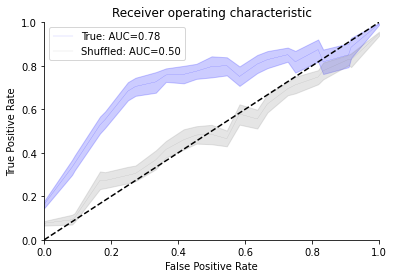

In [6]:
top_feats = fit_and_summary(cdf, SYMPTOM_STATES["1.0"], os.path.join(SRC_DATA_DIR, PR01_STAGEI_MODEL_PERF_FN))

## Frequency of feature selection across 1000 random models

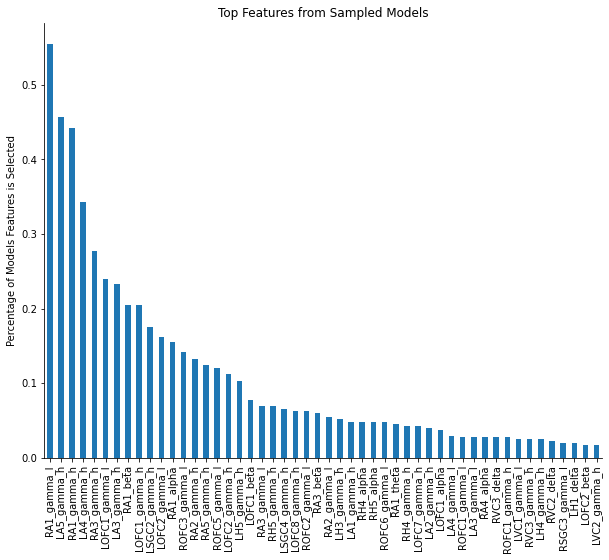

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))
top_feats[:50].plot(kind='bar');
ax.set_ylabel('Percentage of Models Features is Selected')
ax.set_title('Top Features from Sampled Models')
sns.despine();

### My additional Analysis

### what is the time difference between recordings?

C:\Users\ICN_AD~1\AppData\Local\Temp/ipykernel_24192/628846045.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["time_diff_hours"][1:] = td.apply(lambda x: x.total_seconds()/3600)


Text(0.5, 1.0, 'Time Difference between subsequent measurements')

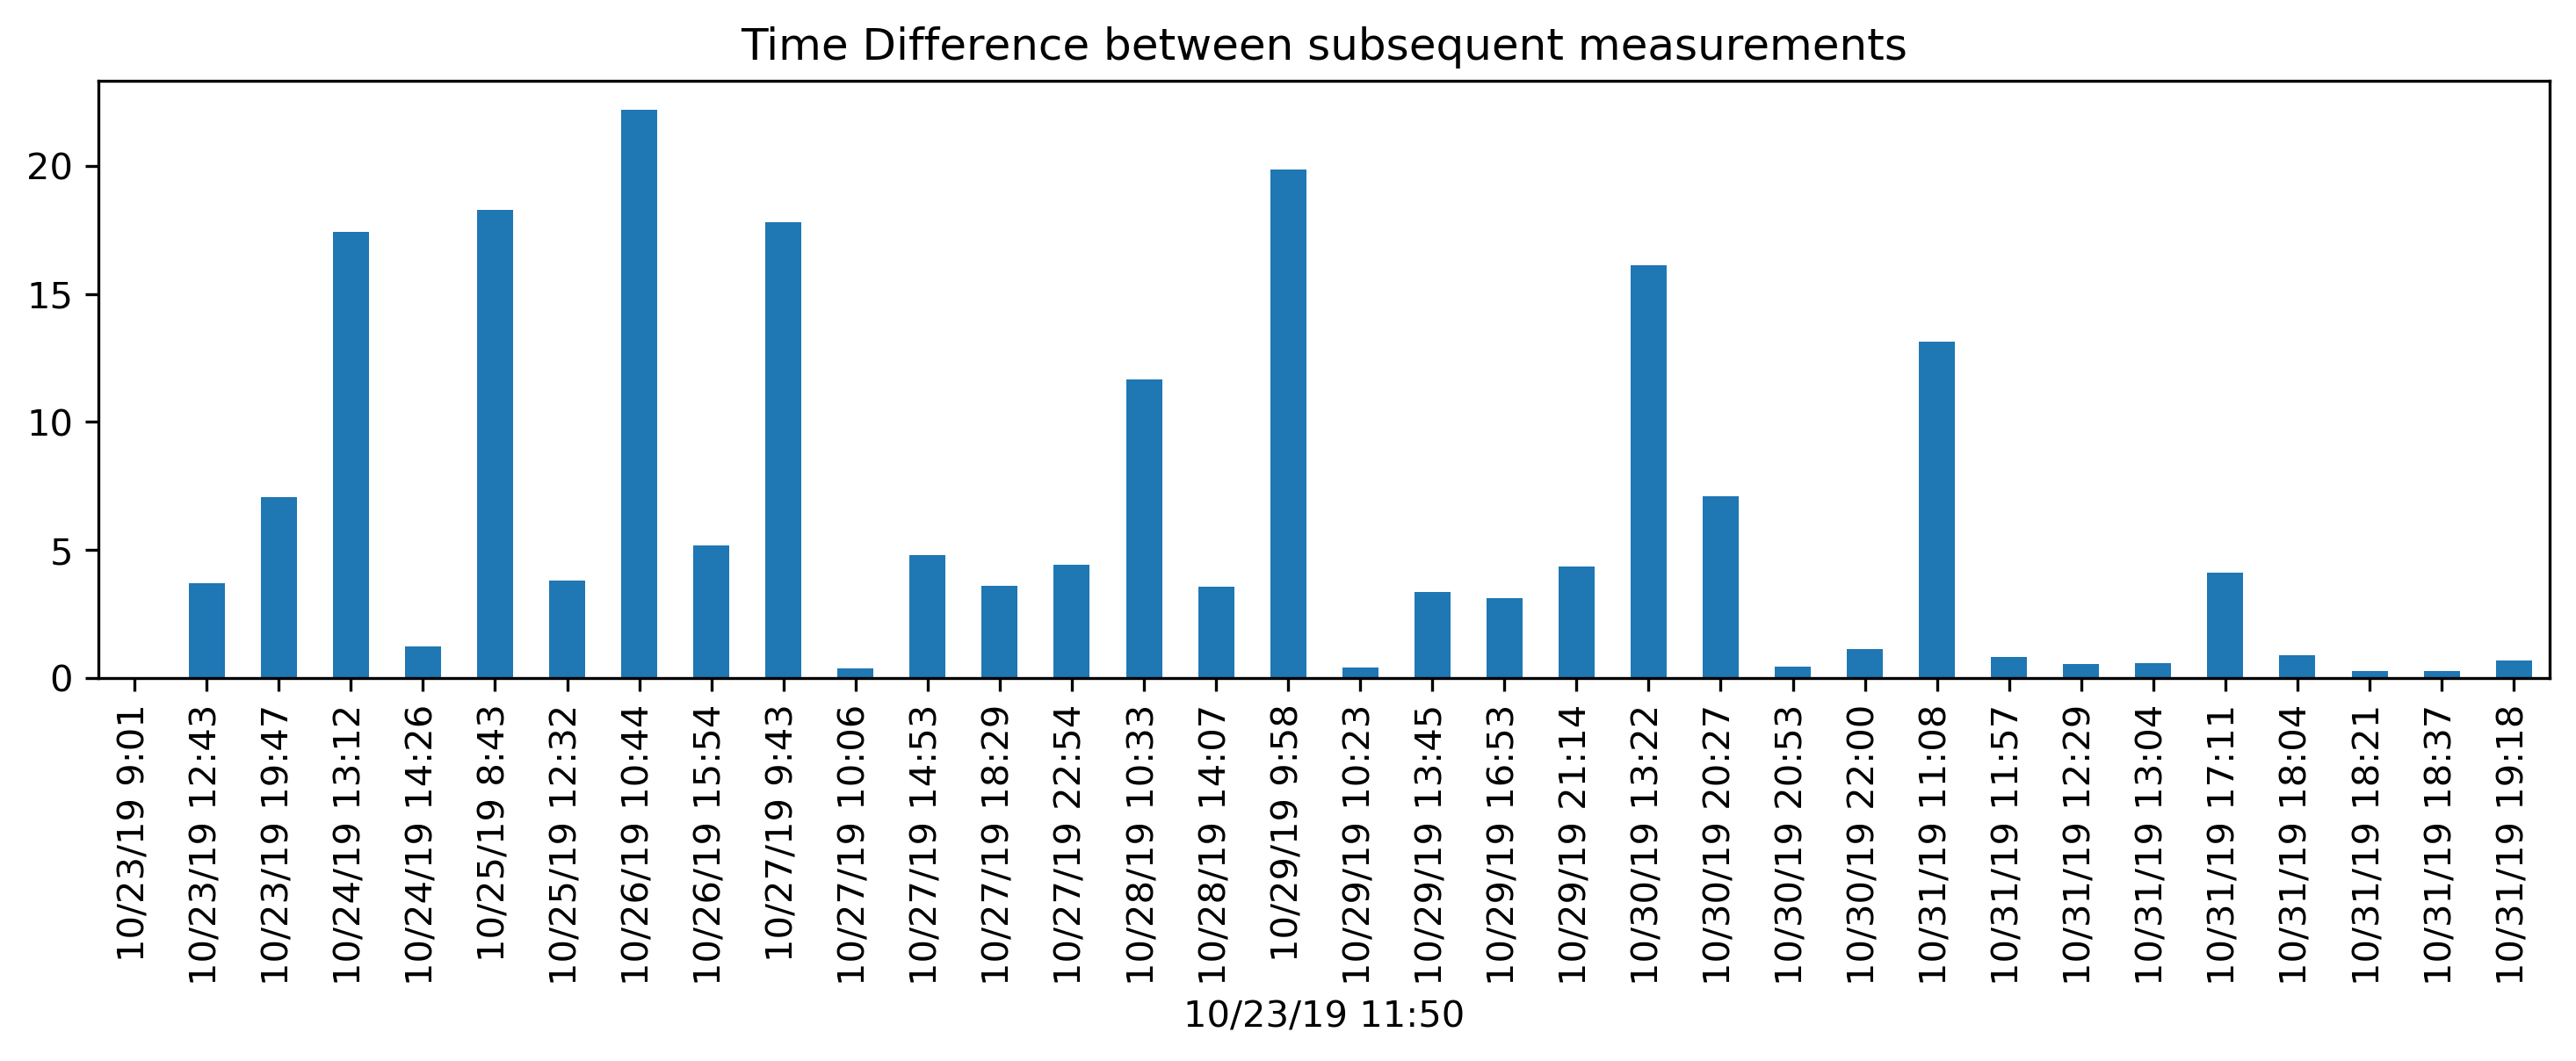

In [26]:
y, X = SYMPTOM_STATES["1.0"], cdf

X["time"] = X.index
X["time"] = pd.to_datetime(X["time"])

X = X.sort_values("time")

td = pd.to_datetime(X["time"][1:]).reset_index()["time"] - \
    pd.to_datetime(X["time"][:-1]).reset_index()["time"]

X["time_diff_hours"] = None

X["time_diff_hours"][1:] = td.apply(lambda x: x.total_seconds()/3600)

plt.figure(figsize=(12,3), dpi=300)
X["time_diff_hours"].plot(kind="bar")
plt.title("Time Difference between subsequent measurements")

Text(0.5, 1.0, 'Time Difference between subsequent measurements\n blue=low symptom, red = high symptom')

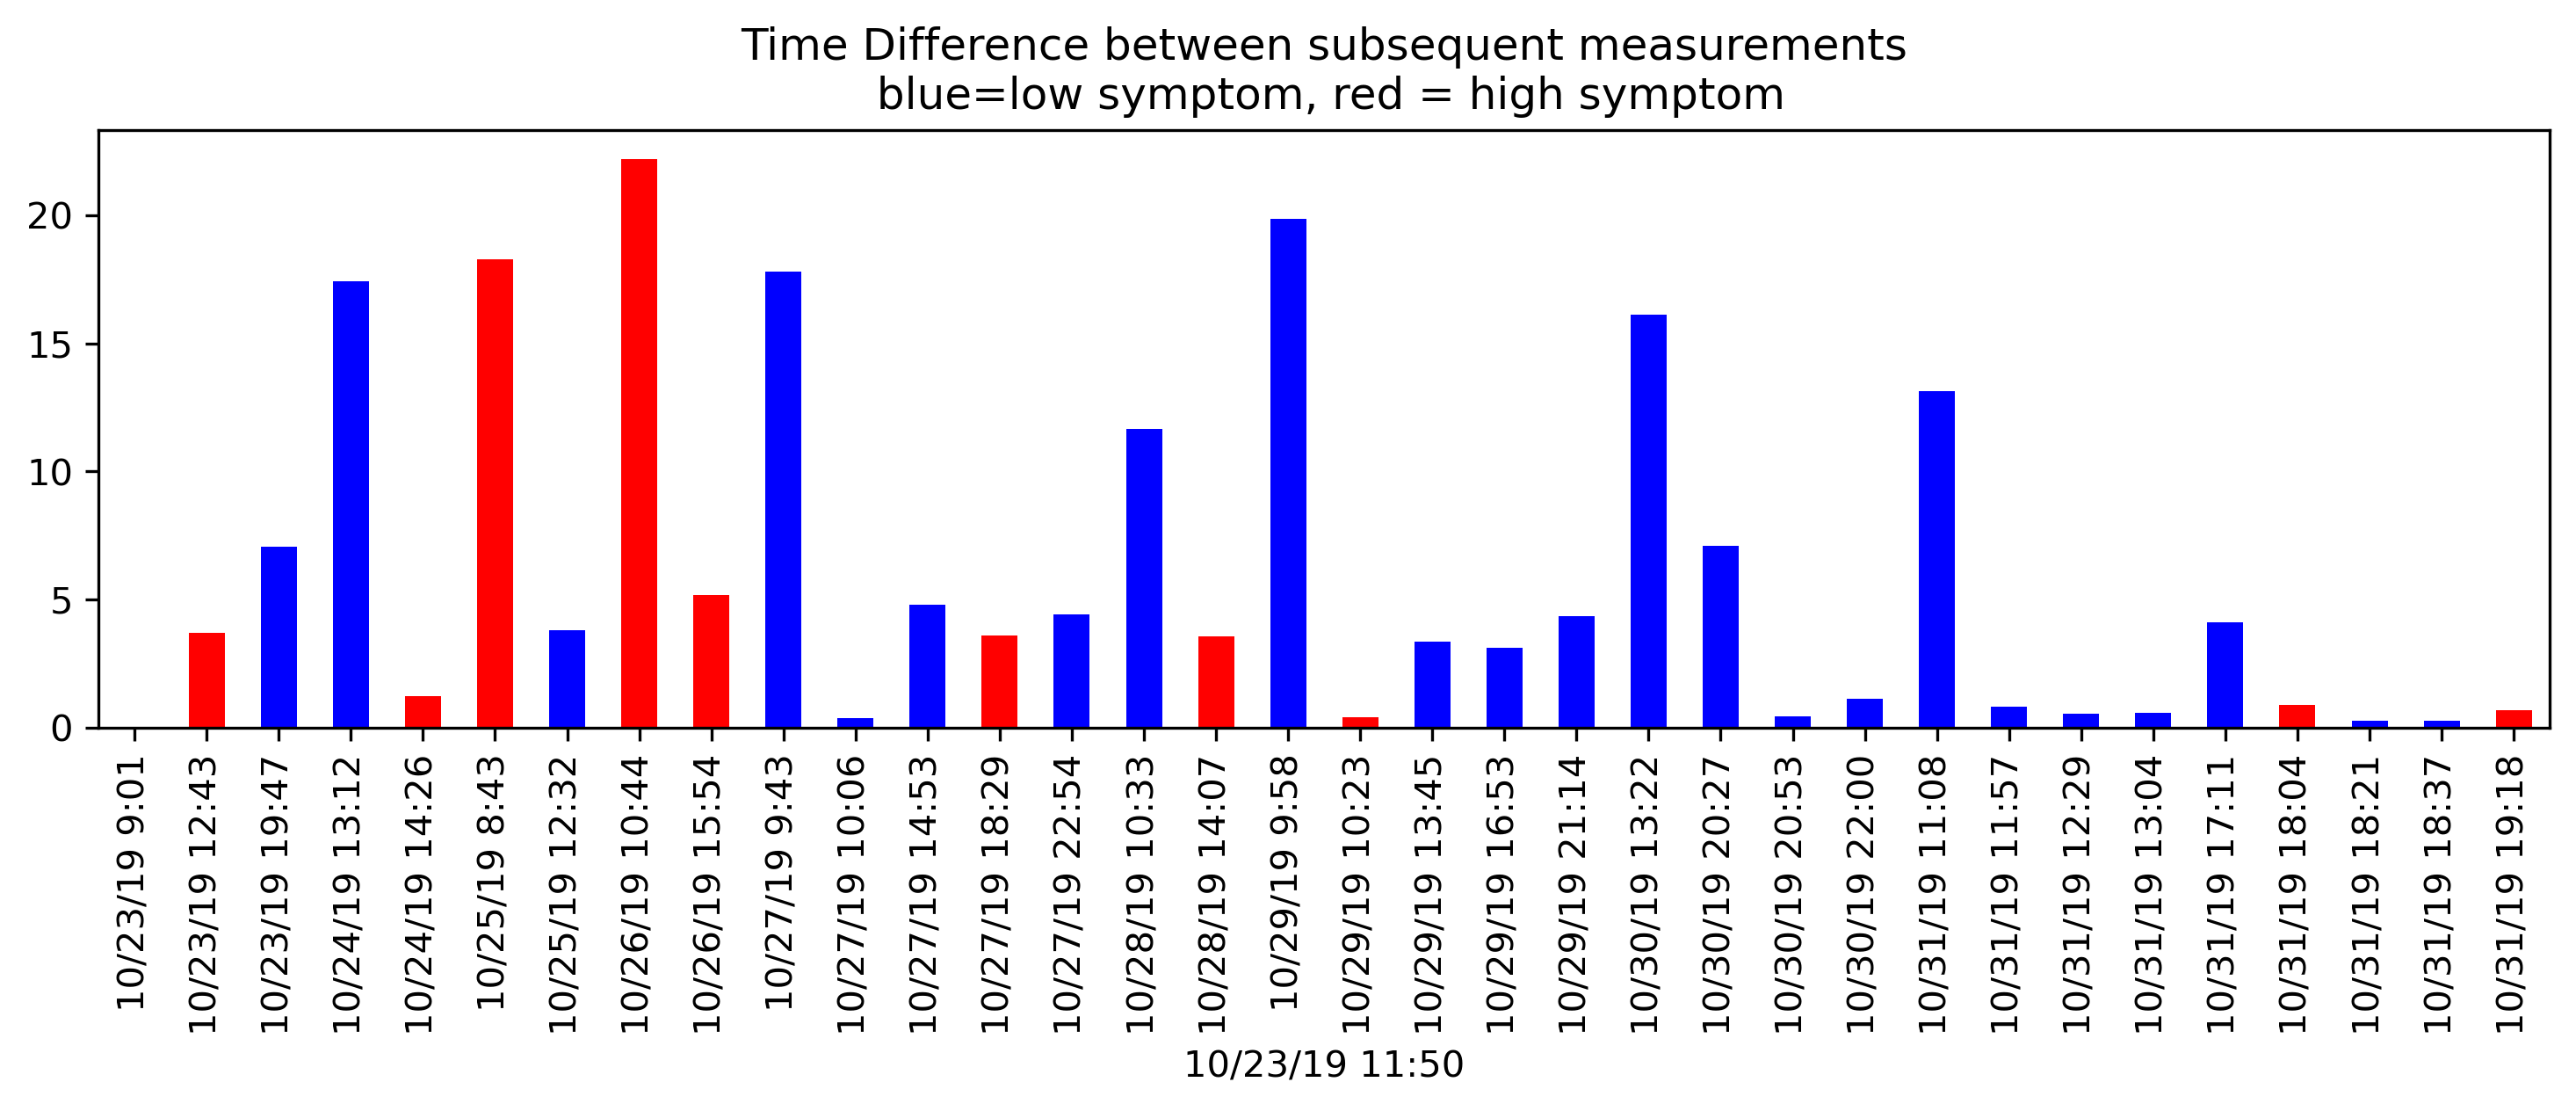

In [27]:
plt.figure(figsize=(12,3), dpi=300)
X["time_diff_hours"].plot.bar(color=y[1:].apply(lambda y: "blue" if y==0 else "red"))
plt.title("Time Difference between subsequent measurements\n blue=low symptom, red = high symptom")

### most high symptom states are in the beginning

### check if classes are balanced?

In [10]:
y, X = SYMPTOM_STATES["1.0"], cdf

In [11]:
y.shape

(34,)

In [12]:
y.sum()

11.0

### How many brain regions were measured?

In [31]:
brain_areas = np.unique([i.split('_')[0] for i in list(X.columns) if "time" not in i])
brain_areas

array(['LA1', 'LA2', 'LA3', 'LA4', 'LA5', 'LH1', 'LH2', 'LH3', 'LH4',
       'LH5', 'LOFC1', 'LOFC2', 'LOFC6', 'LOFC7', 'LOFC8', 'LSGC2',
       'LSGC3', 'LSGC4', 'LVC1', 'LVC2', 'LVC3', 'RA1', 'RA2', 'RA3',
       'RA4', 'RA5', 'RH3', 'RH4', 'RH5', 'ROFC1', 'ROFC2', 'ROFC3',
       'ROFC5', 'ROFC6', 'RSGC3', 'RSGC4', 'RSGC5', 'RSGC6', 'RVC1',
       'RVC2', 'RVC3'], dtype='<U5')

### How many frequency bands?

In [14]:
np.unique([i.split('_')[1] for i in list(X.columns) if "time" not in i])

array(['alpha', 'beta', 'delta', 'gamma', 'theta'], dtype='<U5')

### How are features correlated for a single area?

<AxesSubplot:>

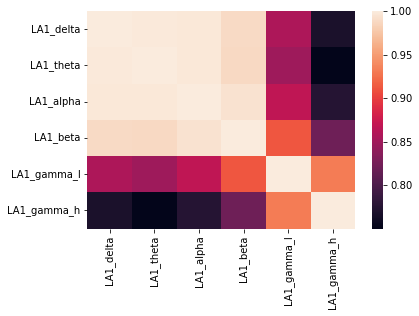

In [15]:
features_ = X[[i for i in list(X.columns) if "LA1" in i]]

corr = features_.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

### Distribution of features

<AxesSubplot:>

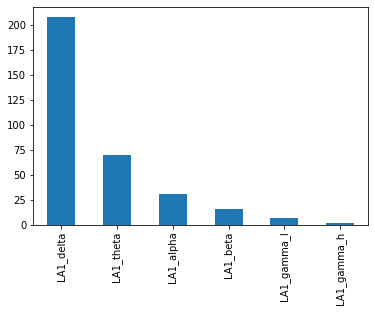

In [19]:
features_.mean(axis=0).plot(kind="bar")

#### Normalize data

In [22]:
from scipy import stats

features_ = stats.zscore(features_, axis=0)

### plot features over time

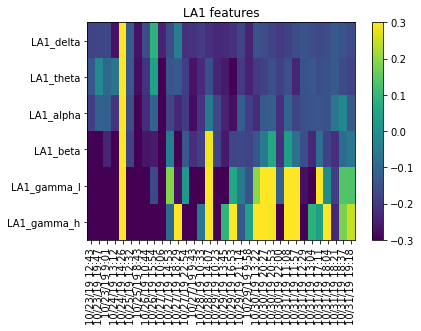

In [24]:
plt.imshow(features_.T, aspect='auto')
plt.clim(-0.3, 0.3)
plt.yticks(range(len(features_.columns)), features_.columns)
plt.xticks(range(len(features_.index)), features_.index, rotation=90)
plt.title("LA1 features")
plt.colorbar()
plt.show()

### check if PCA can perform a meaningful dimensionality reduction

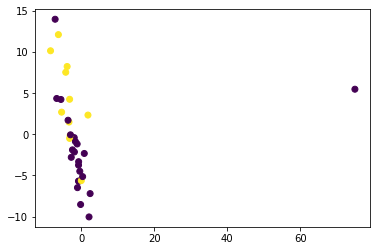

In [29]:
from sklearn import decomposition

features_all = X.loc[:, (X.columns != "time") & (X.columns != "time_diff_hours")]
features_all = stats.zscore(features_all, axis=0)

pca_ = decomposition.PCA(n_components=2)
pca_.fit(features_all)

features_pca = pca_.transform(features_all)

plt.scatter(features_pca[:,0], features_pca[:,1], c=y)

### Plot features separated by classes for each brain area

In [33]:
brain_areas = np.unique([i.split('_')[0] for i in list(X.columns) if "time" not in i])

In [35]:
features_all = X.loc[:, (X.columns != "time") & (X.columns != "time_diff_hours")]
features_all = stats.zscore(features_all, axis=0)

C:\Users\ICN_AD~1\AppData\Local\Temp/ipykernel_24192/906015268.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_high = pd.melt(df_region[y==0])
C:\Users\ICN_AD~1\AppData\Local\Temp/ipykernel_24192/906015268.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_low = pd.melt(df_region[y==1])
C:\Users\ICN_AD~1\AppData\Local\Temp/ipykernel_24192/906015268.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_high = pd.melt(df_region[y==0])
C:\Users\ICN_AD~1\AppData\Local\Temp/ipykernel_24192/906015268.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_low = pd.melt(df_region[y==1])
C:\Users\ICN_AD~1\AppData\Local\Temp/ipykernel_24192/906015268.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_high = pd.melt(df_region[y==0])
C:\Users\ICN_AD~1\AppData\Local\Temp/ipykernel_24192/906015268.py:4: UserWarning: Boolean Se

C:\Users\ICN_AD~1\AppData\Local\Temp/ipykernel_24192/906015268.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_high = pd.melt(df_region[y==0])
C:\Users\ICN_AD~1\AppData\Local\Temp/ipykernel_24192/906015268.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_low = pd.melt(df_region[y==1])
C:\Users\ICN_AD~1\AppData\Local\Temp/ipykernel_24192/906015268.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_high = pd.melt(df_region[y==0])
C:\Users\ICN_AD~1\AppData\Local\Temp/ipykernel_24192/906015268.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_low = pd.melt(df_region[y==1])
C:\Users\ICN_AD~1\AppData\Local\Temp/ipykernel_24192/906015268.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_high = pd.melt(df_region[y==0])
C:\Users\ICN_AD~1\AppData\Local\Temp/ipykernel_24192/906015268.py:4: UserWarning: Boolean Se

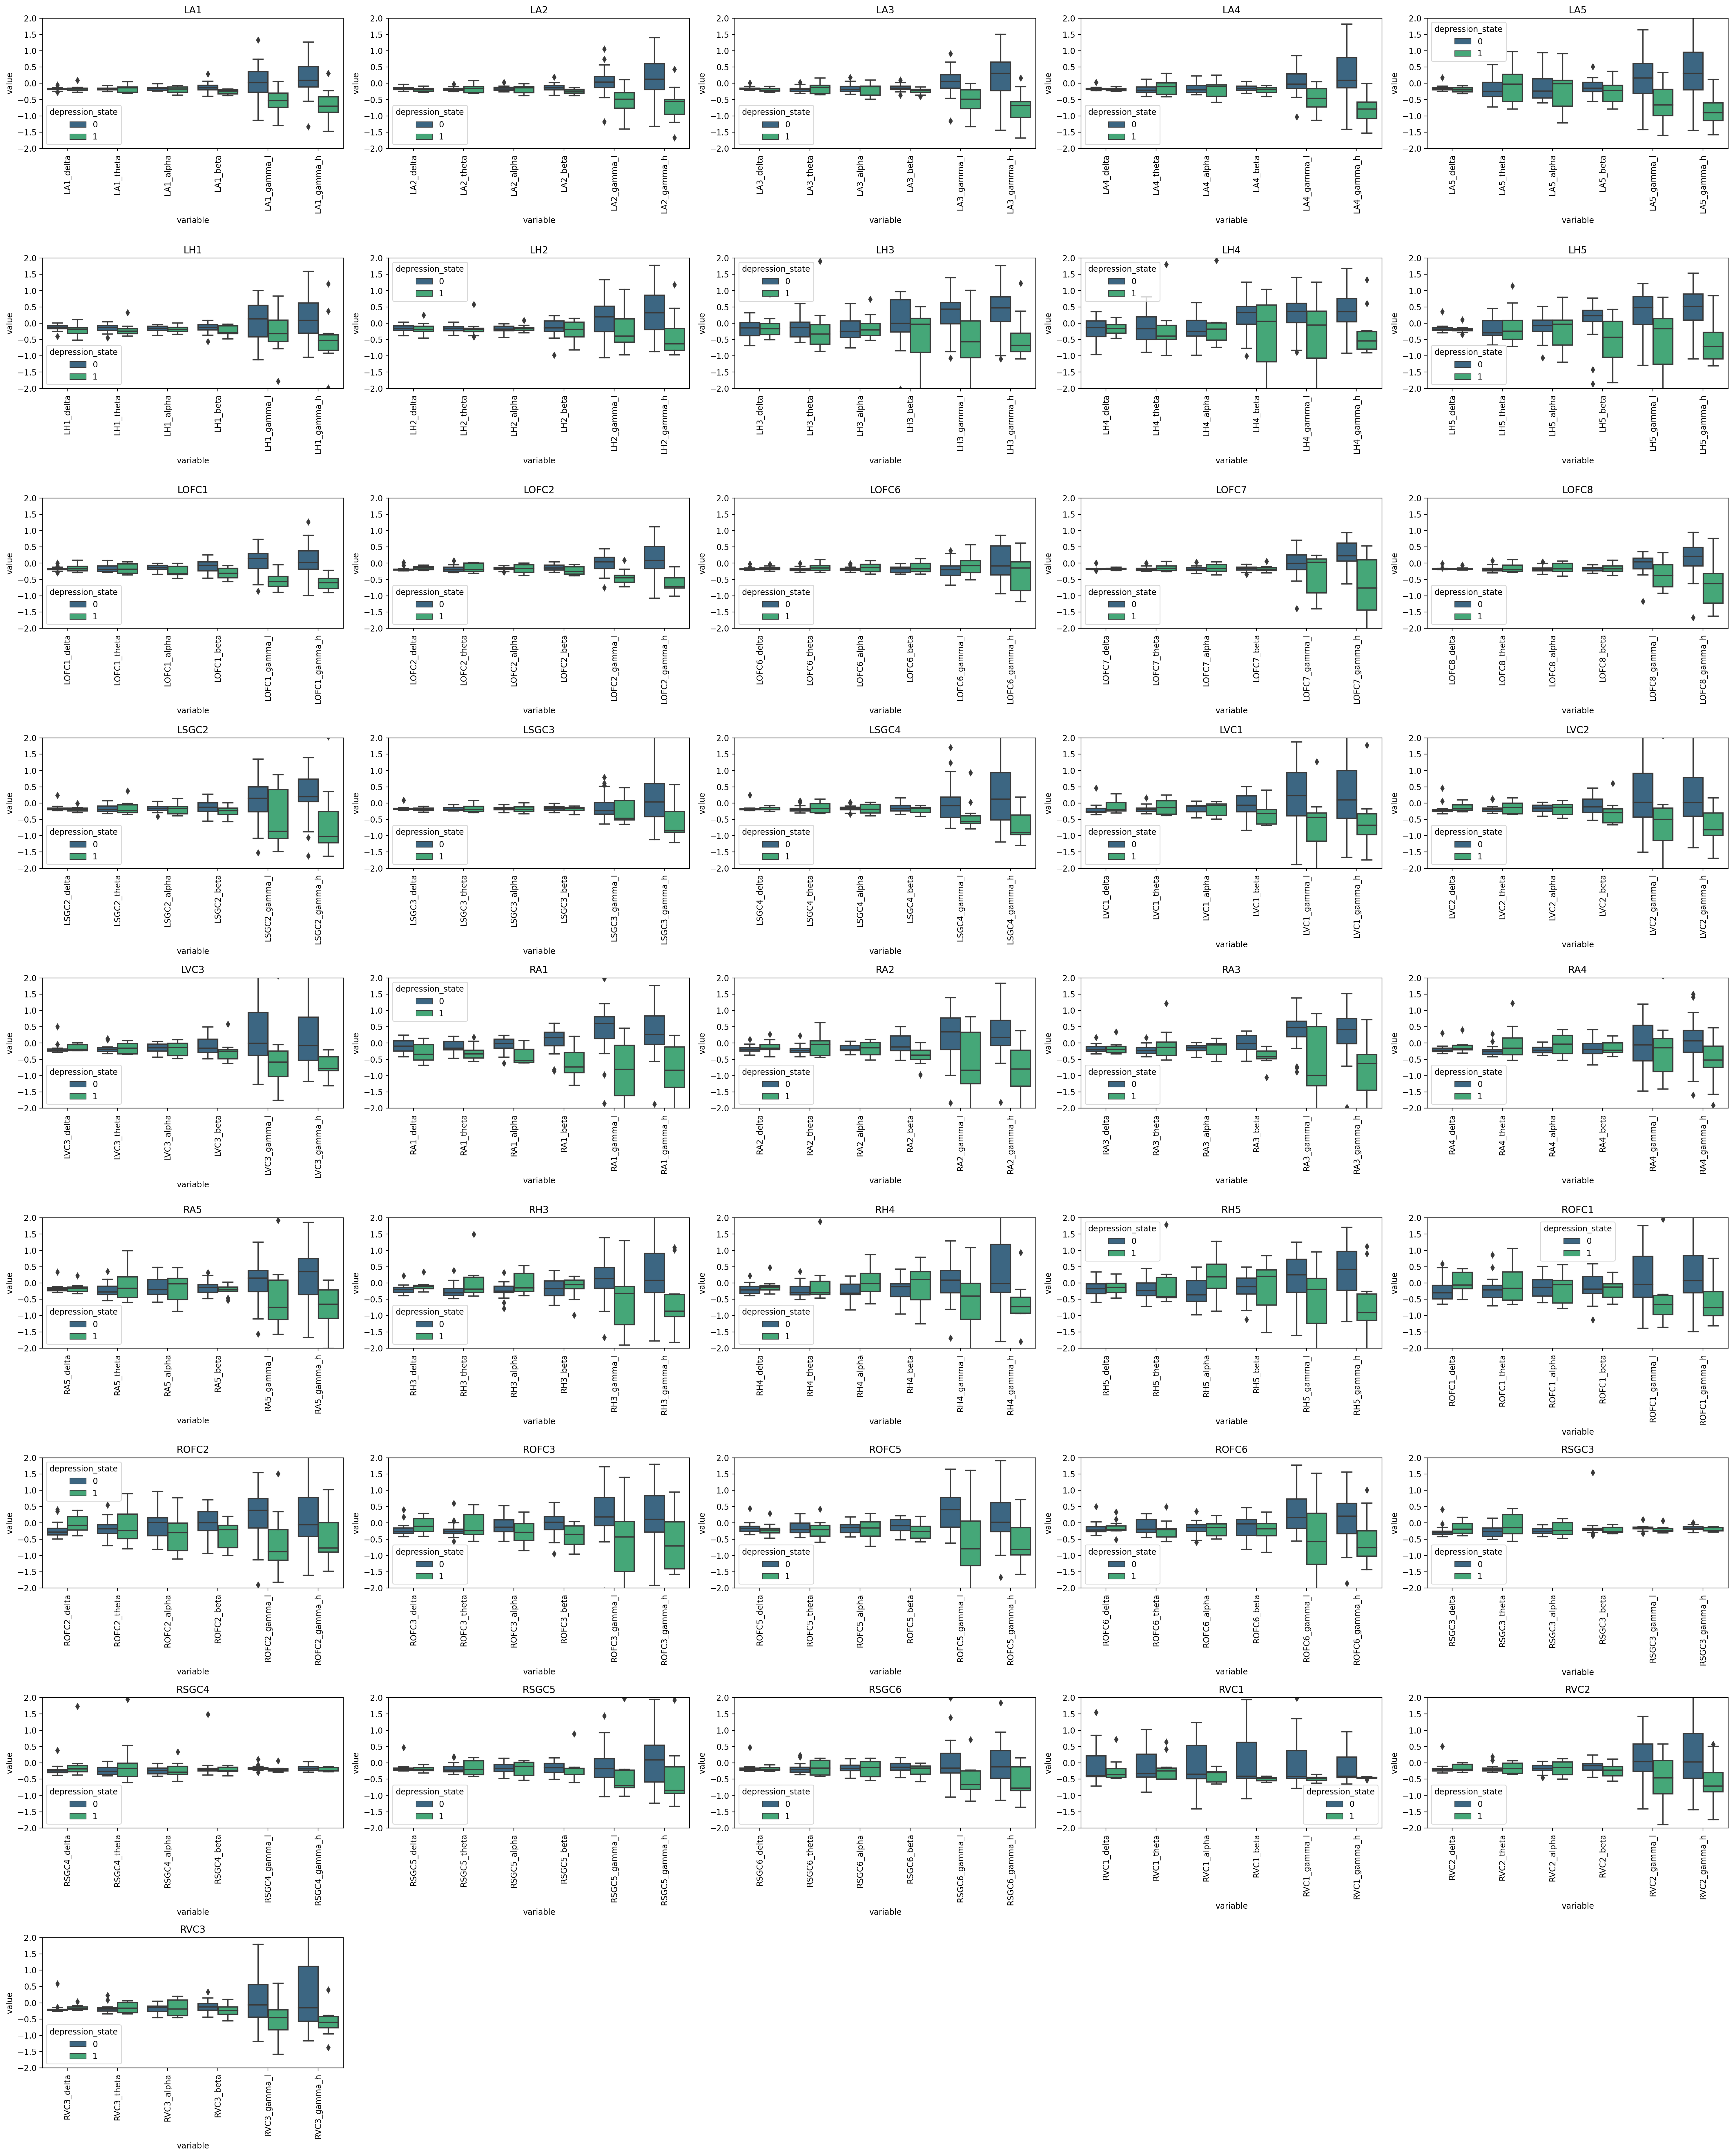

In [38]:
def get_sb_df(df_region):
    df_high = pd.melt(df_region[y==0])
    df_high["depression_state"] = 0
    df_low = pd.melt(df_region[y==1])
    df_low["depression_state"] = 1
    return pd.concat([df_high, df_low])

plt.figure(figsize=(30, 40), dpi=200)
for idx, brain_area in enumerate(brain_areas):
    plt.subplot(10,5, idx+1)
    df_sns = get_sb_df(features_all[[i for i in list(features_all.columns) if brain_area in i]])
    sns.boxplot(data=df_sns, x="variable", y="value", hue="depression_state", palette="viridis")
    plt.xticks(rotation=90)
    plt.ylim(-2,2)
    plt.title(brain_area)

plt.tight_layout()
plt.show()